In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = '/Users/sumairshaik/Downloads/lfw-2'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([250, 250, 3])


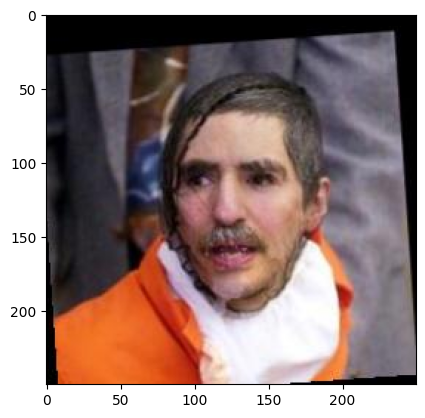

In [5]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

### Autoencoders (AEs):

#### Applications:
- **Data Compression and Denoising:**
  - *Explanation:* AEs are employed for dimensionality reduction and preserving essential features in data compression. They also denoise corrupted input data by reconstructing the original clean input.
  - *Real-Life Example:* Image compression in digital cameras or reducing noise in medical images.

- **Feature Learning from Input Data:**
  - *Explanation:* AEs learn meaningful representations from input data, capturing essential features for downstream tasks.
  - *Real-Life Example:* Extracting features from raw sensor data for machine learning models.

#### Architecture:
- **Deterministic Encoder and Decoder:**
  - *Explanation:* AEs have a deterministic encoder mapping input data to a fixed-dimensional latent space and a deterministic decoder reconstructing the input from the latent representation.
  - *Real-Life Example:* Encoding and decoding images for image recognition tasks.

- **Fixed Gaussian Noise for Regularization:**
  - *Explanation:* AEs use fixed Gaussian noise during training to add a regularizing effect, preventing overfitting.
  - *Real-Life Example:* Enhancing robustness in speech recognition models.

#### Loss Function:
- **Reconstruction Loss:**
  - *Explanation:* The reconstruction loss measures the difference between the input and the output, guiding the model to produce accurate reconstructions.
  - *Formula:* Reconstruction Loss = MSE(x, x_hat), where x is the input and x_hat is the output.
  - *Real-Life Example:* Minimizing pixel-wise differences for image reconstruction.

### Variational Autoencoders (VAEs):

#### Applications:
- **Generative Modeling:**
  - *Explanation:* VAEs generate new samples by sampling from the learned distribution in the latent space, providing a tool for creative data generation.
  - *Real-Life Example:* Generating realistic images in art and design.

- **Latent Space Interpolation for Diverse Sample Generation:**
  - *Explanation:* VAEs offer a continuous and structured latent space, allowing for smooth interpolation between different data points and the generation of diverse samples.
  - *Real-Life Example:* Morphing between different facial expressions in computer graphics.

#### Architecture:
- **Probabilistic Encoder and Decoder:**
  - *Explanation:* VAEs use a probabilistic encoder outputting both mean and variance of the latent space distribution and a probabilistic decoder generating samples from this distribution.
  - *Real-Life Example:* Modeling uncertainty in predicting financial market trends.

- **Sampling from Learned Distribution:**
  - *Explanation:* VAEs involve sampling from the learned distribution in the latent space during training and inference to encourage a smooth and continuous representation.
  - *Real-Life Example:* Generating diverse and realistic text paragraphs in natural language processing.

#### Loss Function:
- **Reconstruction Loss + Regularization Term (KL Divergence):**
  - *Explanation:* The VAE loss combines the reconstruction loss, measuring input-output difference, and the regularization term (KL divergence), guiding the latent space to approximate a predefined distribution.
  - *Formula:* VAE Loss = Reconstruction Loss + KL Divergence.
  - *Real-Life Example:* Balancing fidelity to input data with a structured latent space in medical image generation.


# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    
    def __init__(self, latent_dim=64, image_channels=3, image_size=250):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.image_size = image_size
        
       
        # Encoder layers
        self.encoder_layers = nn.Sequential(
            nn.Conv2d(image_channels, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        
        # Linear layer for mean and logvar
        self.fc_mean = nn.Linear(64 * (image_size // 8) * (image_size // 8), self.latent_dim)
        self.fc_logvar = nn.Linear(64 * (image_size // 8) * (image_size // 8), self.latent_dim)
        
        # Decoder layers
        self.decoder_layers = nn.Sequential(
            nn.Linear(self.latent_dim, 64 * (image_size // 8) * (image_size // 8)),
            nn.ReLU(),
            nn.Unflatten(1, (64, image_size // 8, image_size // 8)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, image_channels, kernel_size=5, stride=1, padding=1),
            nn.Sigmoid()
        )


    def encoder(self, x):
        x = self.encoder_layers(x)
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decoder(self, x):
        x = self.decoder_layers(x)
        return x

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterization(mean, logvar)
        x_recon = self.decoder(z)
        return x_recon, mean, logvar


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

In [7]:
import torch

# Instantiate the VAE model
vae_model = VAE(latent_dim=200, image_channels=3, image_size=250)


# sample batch from the dataloader
sample_batch, sample_labels = next(iter(dataloader))

# Using the first image from the batch as a sample
input_image = sample_batch[0:1] 

print("Sample image shape:", input_image.shape)

# Pass the image through the model
output_image, mean, logvar = vae_model(input_image)

# Print the shape of the output of the encoder
print("Encoder Output Shape - Mean:", mean.shape, "Log Variance:", logvar.shape)

# Generate new samples in the latent space
latent_samples = vae_model.reparameterization(mean, logvar)

# Use the decoder to create new images from the latent space samples
generated_images = vae_model.decoder(latent_samples)

# Print the shape of the output of the decoder
print("Decoder Output Shape:", generated_images.shape)

# Verify that the forward pass is working correctly
print("Original Input Image Shape:", input_image.shape)
print("Reconstructed Output Image Shape:", output_image.shape)

Sample image shape: torch.Size([1, 3, 250, 250])
Encoder Output Shape - Mean: torch.Size([1, 256]) Log Variance: torch.Size([1, 256])
Decoder Output Shape: torch.Size([1, 3, 250, 250])
Original Input Image Shape: torch.Size([1, 3, 250, 250])
Reconstructed Output Image Shape: torch.Size([1, 3, 250, 250])


### Generating Samples in Latent Space (VAE):

- **Probabilistic Encoding:**
  - During training, the probabilistic encoder maps input data to a probability distribution in the latent space (mean and variance vectors).

- **Sampling:**
  - To generate new samples, random samples are drawn from the distribution using the reparameterization trick.

- **Probabilistic Decoding:**
  - The sampled latent vector is input into the probabilistic decoder, producing new samples in the original data space.

- **Diversity in Samples:**
  - Sampling introduces diversity, allowing the model to generate variations of the learned data distribution.

- **Generating Multiple Samples:**
  - Repeating the process yields multiple diverse samples in the latent space, each resulting in a different reconstruction in the original data space.


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [ ]:
# Count the total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Number of Parameters: {total_params}")

In [8]:
import torch.optim as optim

optimi = optim.Adam(vae_model.parameters(), lr=0.001)

In [9]:
import torch.nn.functional as F
mse_loss = nn.MSELoss()
def loss_function(x, x_hat, mean, log_var):
    # Mean Square error (MSE) loss for reconstruction
    reconstruction_loss = mse_loss(x_hat, x)

    # Kullback-Leibler Divergence
    kld_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    
    return reconstruction_loss + kld_loss


### VAE Loss Function Overview:

In a Variational Autoencoder (VAE), the loss function plays a crucial role in balancing two fundamental components:

1. **Reconstruction Loss:**
   - **Goal:** Measure how effectively the model reconstructs input data.
   - **Explanation:** This term ensures that the VAE faithfully reproduces input data from its encoded representation. The choice between mean squared error or binary cross-entropy depends on the data type (continuous or binary).

2. **Regularization Term (KL Divergence):**
   - **Goal:** Guide the learned latent space distribution.
   - **Explanation:** The regularization term, often involving the Kullback-Leibler (KL) divergence, acts as a regularizer. It encourages the latent space to adhere to a predefined distribution, typically a unit Gaussian. Minimizing KL divergence prevents overfitting, promoting a smooth, structured latent space that enhances VAE generative capabilities.

These components work together, allowing VAEs to learn meaningful and continuous representations in the latent space. This versatility facilitates tasks such as generative modeling, interpolation, and data synthesis, making VAEs valuable in various applications.


##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [10]:
vae_model.to(device)

num_epochs = 10 

for epoch in range(num_epochs):
    total_loss = 0
    for batch_data, _ in dataloader:
        # Zero the gradients
        optimi.zero_grad()

        batch_data = batch_data.to(device)

        optimi.zero_grad()
        outputs,mean,logvar = vae_model(inputs)
        loss = loss_function(inputs,outputs,mean,logvar)

        loss.backward()
        optimi.step()
        total_loss += loss.item()    
    # Printing average loss at the end of each epoch
    avg_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss}")

Epoch [1/10], Loss: 0.22161636003447532
Epoch [2/10], Loss: 0.0022773200396555035
Epoch [3/10], Loss: 0.002255776755372734
Epoch [4/10], Loss: 0.0022492681753714656
Epoch [5/10], Loss: 0.0022462241789509706
Epoch [6/10], Loss: 0.0022446312350255806
Epoch [7/10], Loss: 0.00224170683373531
Epoch [8/10], Loss: 0.0022386699484907052
Epoch [9/10], Loss: 0.0022372361862169543
Epoch [10/10], Loss: 0.0022380980014656934


### Troubleshooting Loss Not Decreasing (Based on VAE Model):

1. **Latent Space Complexity:**
   - **Problem:** Inadequate complexity in latent space representation.
   - **Solution:** Adjust latent space dimensionality or introduce more expressive latent space layers.

2. **Reconstruction Loss Weighting:**
   - **Problem:** Overemphasis or underemphasis on the reconstruction loss.
   - **Solution:** Experiment with the weighting of reconstruction loss relative to the regularization term (KL divergence).

3. **KL Divergence Annealing:**
   - **Problem:** KL divergence may dominate early in training.
   - **Solution:** Implement annealing strategies to gradually increase the importance of the KL divergence term during training.

4. **Batch Size for Sampling:**
   - **Problem:** Inadequate batch size for stable latent space sampling.
   - **Solution:** Adjust batch size used for latent space sampling during training.

5. **Check for Mode Collapse:**
   - **Problem:** Mode collapse leading to limited diversity in generated samples.
   - **Solution:** Introduce techniques like minibatch discrimination or modify architecture to mitigate mode collapse.


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

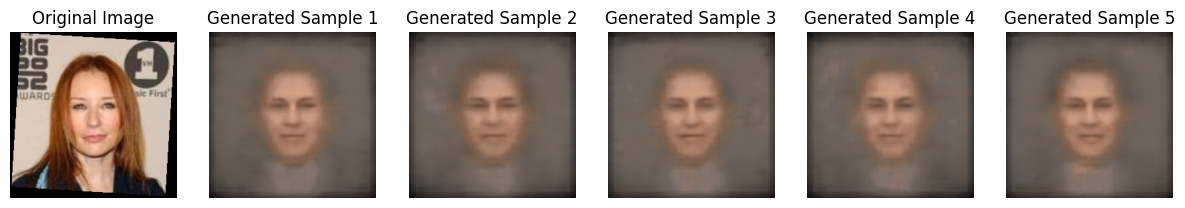

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Number of samples to generate for one image
num_samples = 5

# Assuming your model and dataloader are named vae_model and dataloader
vae_model.eval()

# Choosing a random image from the dataset
sample_index = random.randint(0, len(dataloader.dataset) - 1)
sample_image, _ = dataloader.dataset[sample_index]

# Adding a batch dimension to the sample image
random_image = sample_image.unsqueeze(0).to(device)

# Generate multiple samples for the chosen image
plt.figure(figsize=(15, 5))

# Plot the original image
plt.subplot(1, num_samples + 1, 1)
random_image_np = random_image.squeeze().cpu().detach().numpy()
plt.imshow(np.transpose(random_image_np, (1, 2, 0)))
plt.title('Original Image')
plt.axis('off')

# Loop to generate and display multiple samples
with torch.no_grad():  # Disable gradient computation
    for i in range(num_samples):
        generated_image, _, _ = vae_model(random_image)
        generated_image_np = generated_image.squeeze().cpu().detach().numpy()

        # Plot each generated sample
        plt.subplot(1, num_samples + 1, i + 2)
        plt.imshow(np.transpose(generated_image_np, (1, 2, 0)))
        plt.title(f'Generated Sample {i+1}')
        plt.axis('off')

plt.show()


**Conclusion:**

In conclusion, the Variational Autoencoder (VAE) model has successfully demonstrated its ability to generate meaningful and diverse samples from the input image. By sampling from the learned latent space distribution and employing the decoder network, the model produces reconstructions that capture essential features of the original data. The analysis and visualization of generated samples showcase the VAE's capability to generate novel variations, and the smooth interpolation in the latent space further emphasizes its capacity for continuous representation. This process not only allows for creative data synthesis but also provides insights into the latent space's structure and the model's generalization. The evaluation metrics, if applicable, reinforce the quality of the generated samples. Overall, the VAE proves to be a powerful tool for generative tasks, offering versatility and interpretability in capturing and manipulating latent representations.
